<a href="https://colab.research.google.com/github/rakesh4real/one-or-few-shot-learning/blob/main/matching_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import math, tqdm, random, os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [12]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print('Seed is: ', seed)
    
SEED = 123
seed_everything(SEED)

Seed is:  123


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Load data and perform basic pre-processing

In [14]:
!curl -O https://raw.githubusercontent.com/PacktPublishing/Hands-On-One-shot-Learning-with-Python/master/Chapter02/data/data.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.2M  100 24.2M    0     0  28.1M      0 --:--:-- --:--:-- --:--:-- 28.0M


In [15]:
"""
Load data
"""

x = np.load('data.npy')
print('shape of data: ', x.shape)
x = np.expand_dims(x, axis=4)
print('shape of data after adding color channel: ', x.shape)


"""
train-val-test split
"""

np.random.shuffle(x)
x_train, x_val, x_test = x[:1200], x[1200:1411], x[1411:]

print('train 20 img samples\t: ', len(x_train))
print('val 20 img samples\t: ', len(x_val))
print('test 20 img samples\t: ', len(x_test))

shape of data:  (1623, 20, 28, 28)
shape of data after adding color channel:  (1623, 20, 28, 28, 1)
train 20 img samples	:  1200
val 20 img samples	:  211
test 20 img samples	:  212


In [16]:
"""
Pre-process data (zero center)
"""

def processes_batch(data, mu, sigma):
    return (data - mu) / sigma

# Normalize Dataset
x_train = processes_batch(x_train, np.mean(x_train), np.std(x_train))
x_val = processes_batch(x_val, np.mean(x_val), np.std(x_val))
x_test = processes_batch(x_test, np.mean(x_test), np.std(x_test))

# Defining dictionary of dataset
datatset = {"train": x_train, "val": x_val, "test": x_test}

Set of 20 belonging to same class


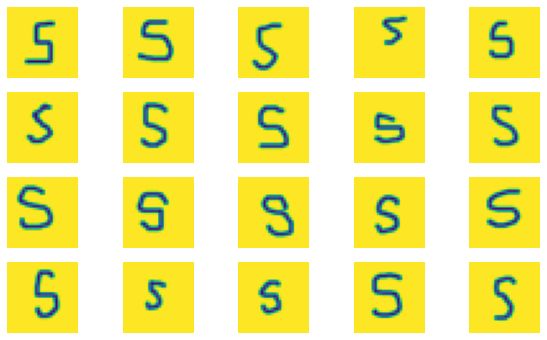

Set of 20 belonging to same class


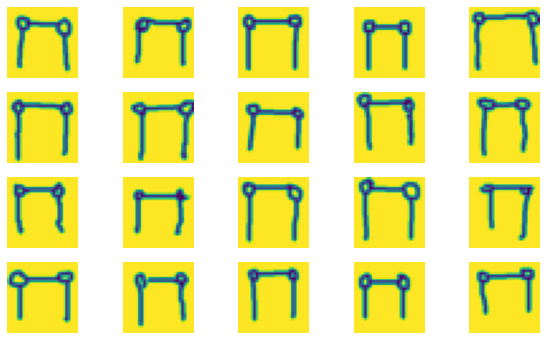

Set of 20 belonging to same class


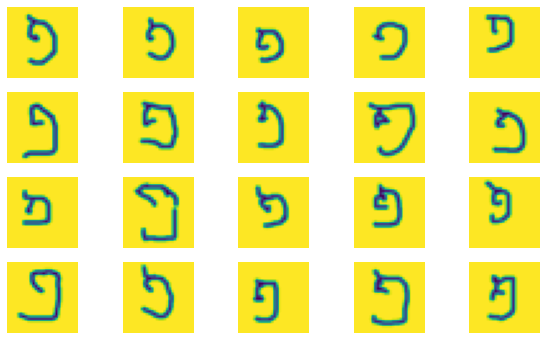

In [17]:
rows = 4
cols = 5

for set_idx in [3, 100, 35]: # idxs of sets to display
  print("="*70)
  print("Set of 20 belonging to same class")
  print("="*70)
  plt.close()

  ffig, axarr = plt.subplots(rows, cols, figsize=(10, 6))
  axarr = axarr.flatten()
  for i in range(len(axarr)):
    axarr[i].imshow(
        np.squeeze(x_train[set_idx,i,:,:,:], axis=2))
    axarr[i].axis('off')
  
  plt.show()

# Omniglot Dataset 

Designed for developing more human-like learning algorithms. Suitable for one-shot learning! Humans can recognize any alphabet by seeing just **one** sample of it. Thus, use `samples_per_class` = `1` (of avilable `20`) to train model.

- Each row (of `1623` rows) has `20` images of same classes. (See `x.shape` above)
- `samples_per_class` = `1` as we are dealing with one shot learning
- `n_classes` = `n_rows` and `classes_per_set` = `20` 

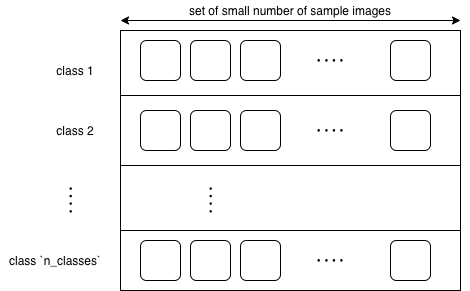

## 2. Matching network related preprocessing

A *batch* in an epoch has

- **Support set:** 
- **Target set:** query point

In [19]:
def sample_batch(data):
        """
        Generates sample batch (by chosing randomly)
        :param : data - (train/test/val dataset) of shape [total_classes,20,28,28,1]
        :return: [support_set_x, support_set_y, target_x, target_y] for Matching Networks
        """
        w, h, c = data.shape[2], data.shape[3], data.shape[4]

        support_set_x = np.zeros((batch_size, classes_per_set, samples_per_class, w, h, c), np.float32)
        support_set_y = np.zeros((batch_size, classes_per_set, samples_per_class), np.int32)
        
        target_x = np.zeros((batch_size, w, h, c), np.float32)
        target_y = np.zeros((batch_size, 1), np.int32)
        
        for i in range(batch_size):
            
            choose_classes = np.random.choice(data.shape[0], size=classes_per_set, replace=False) # chose random classes
            choose_label = np.random.choice(classes_per_set, size=1) # label set
            choose_samples = np.random.choice(data.shape[1], size=samples_per_class + 1, replace=False)
            
            x_temp = data[choose_classes] # choosing classes
            x_temp = x_temp[:, choose_samples] # choosing sample batch from classes chosen outputs 20x2x28x28x1
            y_temp = np.arange(classes_per_set) # will return [0,1,2,3,...,19]
            
            support_set_x[i] = x_temp[:, :-1]
            support_set_y[i] = np.expand_dims(y_temp[:], axis=1)
            target_x[i] = x_temp[choose_label, -1]
            target_y[i] = y_temp[choose_label]

        return support_set_x, support_set_y, target_x, target_y # returns support of [batch_size, 20 classes per set, 1 sample, 28, 28,1]
    
def get_batch(dataset_name):
        """
        gen batch while training
        :param dataset_name: The name of dataset(one of "train","val","test")
        :return: a batch images
        """
        support_set_x, support_set_y, target_x, target_y = sample_batch(datatset[dataset_name])
        support_set_x = support_set_x.reshape((support_set_x.shape[0], support_set_x.shape[1] * support_set_x.shape[2],
                                               support_set_x.shape[3], support_set_x.shape[4], support_set_x.shape[5]))
        support_set_y = support_set_y.reshape(support_set_y.shape[0], support_set_y.shape[1] * support_set_y.shape[2])
        return support_set_x, support_set_y, target_x, target_y

In [20]:
def convLayer(in_channels, out_channels, dropout_prob=0.0):
    """
    :param dataset_name: The name of dataset(one of "train","val","test")
    :return: a batch images
    """
    cnn_seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(True),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(dropout_prob)
    )
    return cnn_seq

class Embeddings_extractor(nn.Module):
    def __init__(self, layer_size=64, num_channels=1, dropout_prob=0.5, image_size=28):
        super(Embeddings_extractor, self).__init__()
        """
        Build a CNN to produce embeddings
        :param layer_size:64(default)
        :param num_channels:
        :param keep_prob:
        :param image_size:
        """
        self.layer1 = convLayer(num_channels, layer_size, dropout_prob)
        self.layer2 = convLayer(layer_size, layer_size, dropout_prob)
        self.layer3 = convLayer(layer_size, layer_size, dropout_prob)
        self.layer4 = convLayer(layer_size, layer_size, dropout_prob)

        finalSize = int(math.floor(image_size / (2 * 2 * 2 * 2)))
        self.outSize = finalSize * finalSize * layer_size

    def forward(self, image_input):
        """
        :param: Image
        :return: embeddings
        """
        x = self.layer1(image_input)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size()[0], -1)
        return x

In [21]:

class AttentionalClassify(nn.Module):
    def __init__(self):
        super(AttentionalClassify, self).__init__()

    def forward(self, similarities, support_set_y):
        """
        Products pdfs over the support set classes for the target set image.
        :param similarities: A tensor with cosine similarites of size[batch_size,sequence_length]
        :param support_set_y:[batch_size,sequence_length,classes_num]
        :return: Softmax pdf shape[batch_size,classes_num]
        """
        softmax = nn.Softmax(dim=1)
        softmax_similarities = softmax(similarities)
        preds = softmax_similarities.unsqueeze(1).bmm(support_set_y).squeeze()
        return preds

In [22]:
class DistanceNetwork(nn.Module):
    """
    This model calculates the cosine distance between each of the support set embeddings and 
    the target image embeddings.
    """

    def __init__(self):
        super(DistanceNetwork, self).__init__()

    def forward(self, support_set, input_image):
        """
        forward pass
        :param support_set:the embeddings of the support set images.shape[sequence_length,batch_size,64]
        :param input_image: the embedding of the target image,shape[batch_size,64]
        :return:shape[batch_size,sequence_length]
        """
        eps = 1e-10
        similarities = []
        for support_image in support_set:
            sum_support = torch.sum(torch.pow(support_image, 2), 1)
            support_manitude = sum_support.clamp(eps, float("inf")).rsqrt()
            dot_product = input_image.unsqueeze(1).bmm(support_image.unsqueeze(2)).squeeze()
            cosine_similarity = dot_product * support_manitude
            similarities.append(cosine_similarity)
        similarities = torch.stack(similarities)
        return similarities.t()

In [23]:

class BidirectionalLSTM(nn.Module):
    def __init__(self, layer_size, batch_size, vector_dim):
        super(BidirectionalLSTM, self).__init__()
        """
        Initial a muti-layer Bidirectional LSTM
        :param layer_size: a list of each layer'size
        :param batch_size: 
        :param vector_dim: 
        """
        self.batch_size = batch_size
        self.hidden_size = layer_size[0]
        self.vector_dim = vector_dim
        self.num_layer = len(layer_size)
        self.lstm = nn.LSTM(input_size=self.vector_dim, num_layers=self.num_layer, hidden_size=self.hidden_size,
                            bidirectional=True)
        self.hidden = (torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size),
                torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size))

    def repackage_hidden(self,h):
        """Wraps hidden states in new Variables, 
        to detach them from their history."""
        if type(h) == torch.Tensor:
            return h.data
        else:
            return tuple(self.repackage_hidden(v) for v in h)
        
    def forward(self, inputs):
        self.hidden = self.repackage_hidden(self.hidden)
        output, self.hidden = self.lstm(inputs, self.hidden)
        return output

In [24]:
class MatchingNetwork(nn.Module):
    def __init__(self, keep_prob, batch_size=32, num_channels=1, learning_rate=1e-3, fce=False, num_classes_per_set=20, \
                 num_samples_per_class=1, image_size=28):
        """
        Matching Network
        :param keep_prob: dropout rate
        :param batch_size:
        :param num_channels:
        :param learning_rate:
        :param fce: Flag indicating whether to use full context embeddings(i.e. apply an LSTM on the CNN embeddings)
        :param num_classes_per_set:
        :param num_samples_per_class:
        :param image_size:
        """
        super(MatchingNetwork, self).__init__()
        self.batch_size = batch_size
        self.keep_prob = keep_prob
        self.num_channels = num_channels
        self.learning_rate = learning_rate
        self.num_classes_per_set = num_classes_per_set
        self.num_samples_per_class = num_samples_per_class
        self.image_size = image_size
        # Let's set all peices of Matching Networks Architecture
        self.g = Embeddings_extractor(layer_size=64, num_channels=num_channels, dropout_prob=keep_prob, image_size=image_size)
        self.f = fce # if we are considering full-context embeddings
        self.c = DistanceNetwork() # cosine distance among embeddings
        self.a = AttentionalClassify() # softmax of cosine distance of embeddings
        if self.f:
            self.lstm = BidirectionalLSTM(layer_size=[32], batch_size=self.batch_size, vector_dim=self.g.outSize)

    def forward(self, support_set_images, support_set_y_one_hot, target_image, target_y):
        """
        Main process of the network
        :param support_set_images: shape[batch_size,sequence_length,num_channels,image_size,image_size]
        :param support_set_y_one_hot: shape[batch_size,sequence_length,num_classes_per_set]
        :param target_image: shape[batch_size,num_channels,image_size,image_size]
        :param target_y:
        :return:
        """
        # produce embeddings for support set images
        encoded_images = []
        for i in np.arange(support_set_images.size(1)):
            gen_encode = self.g(support_set_images[:, i, :, :])
            encoded_images.append(gen_encode)
            
        # produce embeddings for target images
        gen_encode = self.g(target_image)
        encoded_images.append(gen_encode)
        output = torch.stack(encoded_images,dim=0)
        
        # if we are considering full-context embeddings
        if self.f:
            output = self.lstm(output)
            
        # get similarities between support set embeddings and target
        similarites = self.c(support_set=output[:-1], input_image=output[-1])
        
        # produce predictions for target probabilities
        preds = self.a(similarites, support_set_y=support_set_y_one_hot)
        
        # calculate the accuracy
        values, indices = preds.max(1)
        accuracy = torch.mean((indices.squeeze() == target_y).float())
        crossentropy_loss = F.cross_entropy(preds, target_y.long())

        return accuracy, crossentropy_loss

In [25]:
def run_epoch(total_batches, name='train'):
    """
    Run the training epoch
    :param total_train_batches: Number of batches to train on
    :return:
    """
    total_c_loss = 0.0
    total_accuracy = 0.0
    for i in range(int(total_batches)):
            x_support_set, y_support_set, x_target, y_target = get_batch(name)
            x_support_set = torch.from_numpy(x_support_set).float()
            y_support_set = torch.from_numpy(y_support_set).long()
            x_target = torch.from_numpy(x_target).float()
            y_target = torch.from_numpy(y_target).squeeze().long()

            # convert to one hot encoding
            y_support_set = y_support_set.unsqueeze(2)
            sequence_length = y_support_set.size()[1]
            batch_size = y_support_set.size()[0]
            y_support_set_one_hot = torch.zeros(batch_size, sequence_length, 
                            classes_per_set).scatter_(2,y_support_set.data,1)

            # reshape channels and change order
            size = x_support_set.size()
            x_support_set = x_support_set.permute(0, 1, 4, 2, 3)
            x_target = x_target.permute(0, 3, 1, 2)
            acc, c_loss = matchNet(x_support_set, y_support_set_one_hot, x_target, y_target)

            # optimize process
            optimizer.zero_grad()
            c_loss.backward()
            optimizer.step()

            iter_out = "tr_loss: {}, tr_accuracy: {}".format(c_loss, acc)
            total_c_loss += c_loss
            total_accuracy += acc

    total_c_loss = total_c_loss / total_train_batches
    total_accuracy = total_accuracy / total_train_batches
    return total_c_loss, total_accuracy

In [26]:
batch_size=20
num_channels=1
lr=1e-3
image_size=28
classes_per_set=20
samples_per_class=1
keep_prob=0.0
fce=True
optim="adam"
wd=0
matchNet = MatchingNetwork(keep_prob, batch_size, num_channels, lr, fce, classes_per_set,
                                samples_per_class, image_size)
total_iter = 0
total_train_iter = 0
optimizer = torch.optim.Adam(matchNet.parameters(), lr=lr, weight_decay=wd)
scheduler = ReduceLROnPlateau(optimizer, 'min',verbose=True)

# Training setup
total_epochs = 100
total_train_batches = 10
total_val_batches = 5
total_test_batches = 5

In [27]:
train_loss,train_accuracy=[],[]
val_loss,val_accuracy=[],[]
test_loss,test_accuracy=[],[]


for e in range(total_epochs):
    ############################### Training Step ##########################################
    total_c_loss, total_accuracy = run_epoch(total_train_batches,'train')
    train_loss.append(total_c_loss)
    train_accuracy.append(total_accuracy)
    
    ################################# Validation Step #######################################
    total_val_c_loss, total_val_accuracy = run_epoch(total_val_batches, 'val')
    val_loss.append(total_val_c_loss)
    val_accuracy.append(total_val_accuracy)
    print("Epoch {}: train_loss:{:.2f} train_accuracy:{:.2f} valid_loss:{:.2f} valid_accuracy:{:.2f}".
          format(e, total_c_loss, total_accuracy, total_val_c_loss, total_val_accuracy))

Epoch 0: train_loss:2.99 train_accuracy:0.15 valid_loss:1.49 valid_accuracy:0.10
Epoch 1: train_loss:2.95 train_accuracy:0.31 valid_loss:1.48 valid_accuracy:0.12
Epoch 2: train_loss:2.93 train_accuracy:0.37 valid_loss:1.45 valid_accuracy:0.17


KeyboardInterrupt: ignored

In [ ]:
total_test_c_loss, total_test_accuracy = run_epoch(total_test_batches,'test')
print("test_accuracy:{}%".format(total_test_accuracy*100))

test_accuracy:79.0%


In [ ]:
def plot_loss(train,val,name1="train_loss",name2="val_loss",title=""):
    plt.title(title)
    plt.plot(train, label=name1)
    plt.plot(val, label=name2)
    plt.legend()

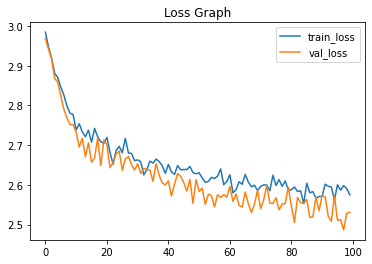

In [ ]:
plot_loss(train_loss,val_loss,"train_loss","val_loss","Loss Graph")

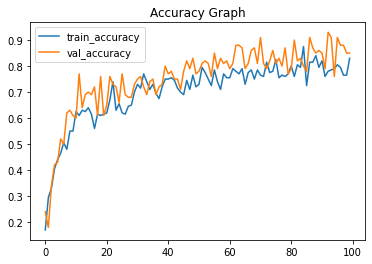

In [ ]:
plot_loss(train_accuracy,val_accuracy,"train_accuracy","val_accuracy","Accuracy Graph")